# 음성 데이터

분석 하기 전 오디오 데이터를 잘 이해할 필요가 있습니다. 이 노트북에서 오디오 데이터의 몇 가지 주요 개념과 기능을 살펴 보겠습니다.

아날로그 사운드의 디지털 표현에 대해 생각해 봅시다. 소리는 어떻게 녹음되는 걸까요? 이미지와 마찬가지로 물리적 세계를 숫자나 디지털 표현으로 변환하여 컴퓨터가 이해할 수 있게 만들 필요가 있습니다. 오디오의 경우, 마이크는 소리를 캡처하는 데 사용되며, 일정한 시간 간격으로 샘플링하여 아날로그 사운드에서 디지털 사운드로 변환됩니다. 이를 `sample rate`라고 부릅니다. 
`sample rate`가 높을수록 소리의 질은 높아지지만 특정 지점 이후에는 사람의 귀에 의해 차이를 탐지할 수 없습니다. 평균 sound sample rate은 48kHz 또는 초당 48,000 samples 입니다. 이 데이터 세트는 16kHz로 sampling되었기 때문에 sample rate는 초당 16,000 samples 입니다.

오디오를 샘플링할 때 소리의 주파수(frequency) 또는 피치(pitch), 진폭(amplitude) 또는 오디오의 음량을 샘플링합니다. 그런 다음 샘플링 속도와 주파수를 사용하여 신호를 시각적으로 나타낼 수 있습니다.
이 시각적 신호는 시간 경과에 따른 신호(signal) 표현인 파형(waveform)으로 그래픽 형식으로 나타낼 수 있습니다. 오디오는 여러 채널(channels)에서 녹음할 수 있습니다. 예를 들어 스테레오 레코딩에는 오른쪽과 왼쪽 두 채널이 있습니다.

이제 오디오 파일을 얻는 방법에 대해 조금 알게 되었습니다. 파일을 구문 분석하는 방법에 대해 잠시 알아보겠습니다. 
예를 들어 오디오 파일이 더 긴 경우 개별적으로 분류할 오디오의 프레임(frames) 또는 섹션으로 나눌 수 있습니다. 이 데이터셋의 경우 각 샘플은 오직 1초 길이의 한 개의 단어이므로 오디오 샘플의 프레임을 설정할 필요가 없습니다. 또 다른 전처리 단계는 파일 시작부터 데이터 로딩을 시작할 프레임 수를 의미하는 오프셋(offset)일 수 있습니다.

## TorchAudio 설정하기

TorchAudio는 PyTorch 기능의 일부로서 I/O 기능, 인기 있는 open dataset 및 모델을 구축하는데 필요한 일반적인 오디오 변환 함수들을 갖추고 있습니다. 이 라이브러리를 사용하여 오디오 데이터로 작업할 것입니다.

시작합시다! 먼저 필요한 패키지를 가져옵니다.

In [1]:
# import the packages
import os
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

## Speech commands Dataset 가져오기 

PyTorch에는 다양한 오디오 모델을 배우고 사용할 때 매우 유용한 다양한 데이터 셋이 기본으로 내장되어 있습니다. 우리는 `Speech Commands`라고 불리는 데이터셋 중 하나를 사용하겠습니다. 전체 데이터셋을 다운로드하지만 `yes`클래스와 `no`클래스만 있는 이진 분류 모델을 만들고자 합니다.

### 폴더 생성하기

In [3]:
default_dir = os.getcwd()
folder = 'data'
print(f'Data directory will be: {default_dir}/{folder}')

if os.path.isdir(folder):
    print("Data folder exists.")
else:
    print("Creating folder.")
    os.mkdir(folder) 

Data directory will be: /home/user/notebooks/data
Creating folder.


### 생성한 데이터 폴더에 Speech Commands 데이터셋 다운로드 하기

In [4]:
trainset_speechcommands = torchaudio.datasets.SPEECHCOMMANDS(f'./{folder}/', download=True)


### 불러온 데이터셋의 class들 살펴보기

In [5]:
os.chdir(f'./{folder}/SpeechCommands/speech_commands_v0.02/')
labels = [name for name in os.listdir('.') if os.path.isdir(name)]
# back to default directory
os.chdir(default_dir)
print(f'Total Labels: {len(labels)}')
print(f'Label Names: {labels}')

Total Labels: 36
Label Names: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', '_background_noise_']


## 소리 데이터를 Tensor로 변환하기

이전에 웨이브 파일을 사용해 본 적이 있을 것이며, 이것이 우리가 공유하고 재생할 아날로그 오디오의 디지털 표현을 저장하는 하나의 형식이라는 것을 알고 있을 것입니다. 이 자습서에 사용하는 Speech Commands dataset에 우리가 사용하는 wave file에는 모두 1초 또는 그 이하의 파형이 저장되어 있습니다.

이제 wave 파일 중 하나를 로드하고 `waveform` 텐서가 어떻게 보여지는지 살펴보겠습니다. 오디오 파일을 `torch.Tensor` 객체로 로드 하는`torchaudio.load`를 사용하여 파일을 로드합니다. TorchAudio는 다양한 오디오 백엔드에 대한 Load 함수가 구현 되어 있으며 데이터를 불러오고 텐서 변환에 대해 우리는 걱정할 필요가 없습니다. `torch.load` 함수는 파형(waveform)을 텐서로 반환하고 `sample_rate`는 정수를 반환합니다.
좀 더 자세한 내용은 이 [Pytorch 공식 문서 링크](https://pytorch.org/audio/stable/backend.html#load)를 참고하세요. 

In [7]:
filename = "./data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav"
waveform, sample_rate = torchaudio.load(filepath=filename, num_frames=3)
print(f'waveform tensor:{waveform}')
waveform, sample_rate = torchaudio.load(filepath=filename, num_frames=3, offset =2)
print(waveform)
waveform, sample_rate = torchaudio.load(filepath=filename)
print(waveform)

waveform tensor:tensor([[0.0005, 0.0007, 0.0005]])
tensor([[0.0005, 0.0004, 0.0007]])
tensor([[0.0005, 0.0007, 0.0005,  ..., 0.0008, 0.0008, 0.0007]])


## waveform 시각화

아래에서는 파형을 표시하고 각 클래스의 샘플을 청취하는 'plot_audio' 함수를 만듭니다.

In [31]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    plt.figure()
    plt.plot(waveform.t().numpy())

    return waveform, sample_rate

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


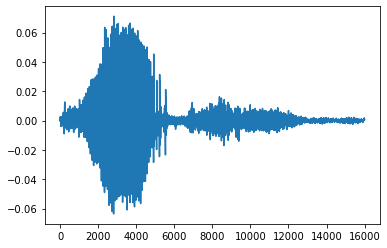

In [32]:
filename = "./data/SpeechCommands/speech_commands_v0.02/yes/00f0204f_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


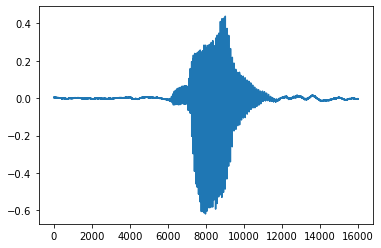

In [34]:
filename = "./data/SpeechCommands/speech_commands_v0.02/no/0b40aa8e_nohash_0.wav"
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)